In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
#from dtw import dtw
from numpy.linalg import norm
import scipy.stats as stats
from sklearn import preprocessing
from itertools import permutations, combinations
import collections

import warnings
warnings.filterwarnings('ignore')

In [2]:
dist_mat = pd.read_csv('../dist_matrix120.csv', index_col=0)
trueData = pd.read_csv('../../dataset/processed.csv', index_col=0)
window_size = 120

In [3]:
trueData['Global_active_power'].head()

DateTime
2006-12-16 17:24:00    2.965329
2006-12-16 17:25:00    4.050626
2006-12-16 17:26:00    4.063907
2006-12-16 17:27:00    4.077189
2006-12-16 17:28:00    2.443552
Name: Global_active_power, dtype: float64

In [4]:
dist_mat = np.array(dist_mat)+np.transpose(np.array(dist_mat))

In [5]:
X=[]
for i in range(0, len(trueData)-window_size, int(window_size/2)):
    X.append(trueData[i:i+window_size]['Global_active_power'].values)

In [6]:
distance_df = pd.DataFrame(dist_mat)

In [7]:
def find_nearest_clust(density_clusters, seq_id, clust_size_cut_off, curr):
    dis_list = []
    for i,j in enumerate(density_clusters):
        dis_buffer = 0
        c = 0
        if i!=curr:
            for k in j:
                dis_buffer += dist_mat[seq_id][k]
                c += 1
        c = max(c,1)
        dis_list.append((dis_buffer/c))
    
    dis_list = [max(dis_list) if x==0 else x for x in dis_list]
    return np.argmin(dis_list, axis=0), min(dis_list)

In [8]:
# Pass in dist_mat: distance matrix
def den_cluster(eps_, reassign=-1):
    density_clusters = []
    density_buffer = []
    
    anomaly_sigs = []
    
    cut_off_dist = eps_
    clust_size_cut_off = min(int(len(X)/200), 3)
    #clust_size_cut_off = max(clust_size_cut_off, 3)

    for i,j in enumerate(dist_mat):
        density_buffer.append(i)
        for k,l in enumerate(j):
            if ((l<=cut_off_dist) and (l>0)):
                if k not in density_buffer:
                    density_buffer.append(k)

        if len(density_buffer)<clust_size_cut_off:
            anomaly_sigs.append(i)

        density_clusters.append(density_buffer)
        density_buffer = []

    density_clusters = sorted(density_clusters, key=len, reverse=True)
 
    
    for i,j in enumerate(density_clusters):
        for l,m in enumerate(density_clusters):
            if l>i:
                density_clusters[l] = list(set(m)-set(j))
    
       
    if reassign==1:
        
        density_clusters = [list(set(x)-set(anomaly_sigs)) for x in density_clusters]
        #print(density_clusters)
        
        for z in range(0, len(density_clusters)):
            if len(density_clusters[z]) >= clust_size_cut_off:
                clus_dis = []
                
                for i in combinations(density_clusters[z], 2):
                    clus_dis.append(dist_mat[i[0],i[1]])
                    
                #print(density_clusters[z])

                #for i in density_clusters[z]:
                i = 0
                while(i<len(density_clusters[z])):
                    
                    #print(i, np.mean(dist_mat[i,list(set(density_clusters[z])-set([i]))]), np.mean(clus_dis))
                    #print(density_clusters[z])
                    
                    if np.mean(dist_mat[density_clusters[z][i],list(set(density_clusters[z])-set([density_clusters[z][i]]))])> (np.mean(clus_dis)):
                        density_clusters.append([density_clusters[z][i]])
                        #print(density_clusters[z][i])
                        density_clusters[z].remove(density_clusters[z][i])
                        
                    else:
                        i+=1


        density_clusters = sorted(density_clusters, key=len, reverse=False)
        density_clusters = [x for x in density_clusters if x != []]
        #print(density_clusters)
        for i,j in enumerate(density_clusters):
            if len(density_clusters[i])<=clust_size_cut_off:
                #print(i-1, density_clusters[max(i-1, 0)])
                #print(i, density_clusters[i])
                clus_buff = density_clusters[i][:]
                for k in density_clusters[i]:
                    near_, value = find_nearest_clust(density_clusters, k, clust_size_cut_off, i)
                    #print(k, near_, value)
                    density_clusters[near_].append(k)
                    clus_buff.remove(k) 
                
                density_clusters[i] = clus_buff[:]
                #print(i, density_clusters[i])
                density_clusters = sorted(density_clusters, key=len, reverse=False)
                #print(i, density_clusters[i],"\n","\n")
    
    density_clusters = [x for x in density_clusters if x != []]
    
        
    return density_clusters, clust_size_cut_off

In [9]:
eps = 0.025
density_clusters, cut_off = den_cluster(eps, reassign=1)


Wavelet Count 34586 Cluster Count: 21 Cluster size cut off: 3 EPS:  0.025
Cluster Size: 57 Cluster # 0


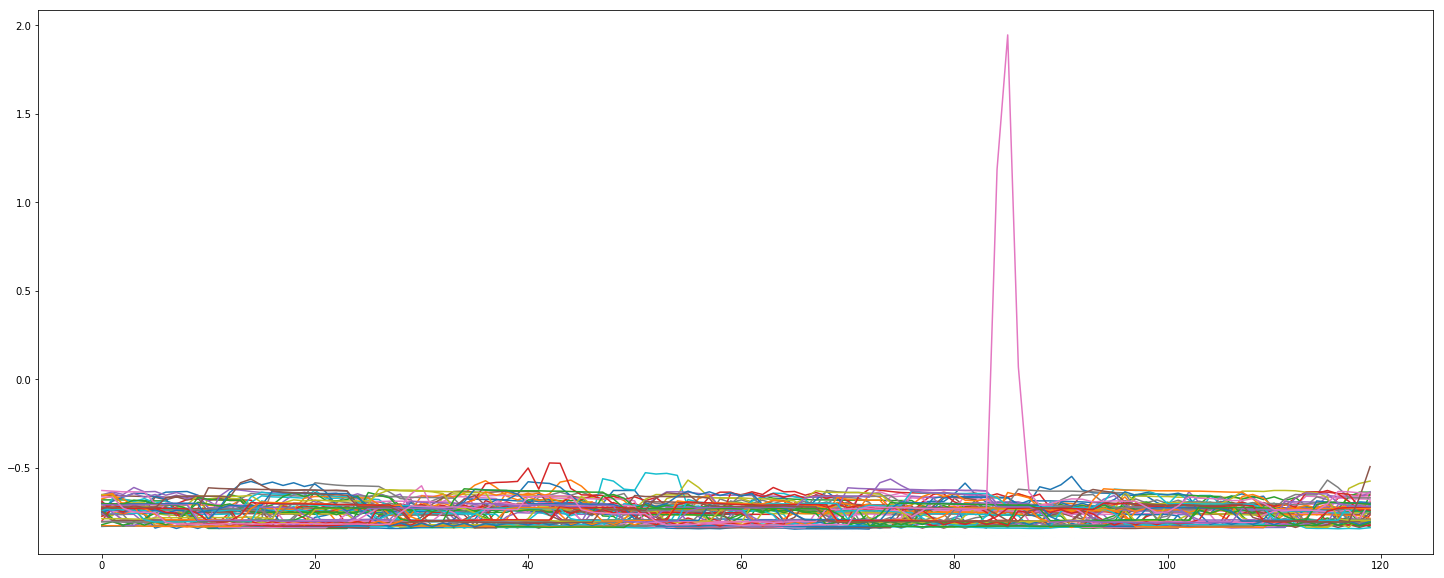

Cluster Size: 20 Cluster # 1


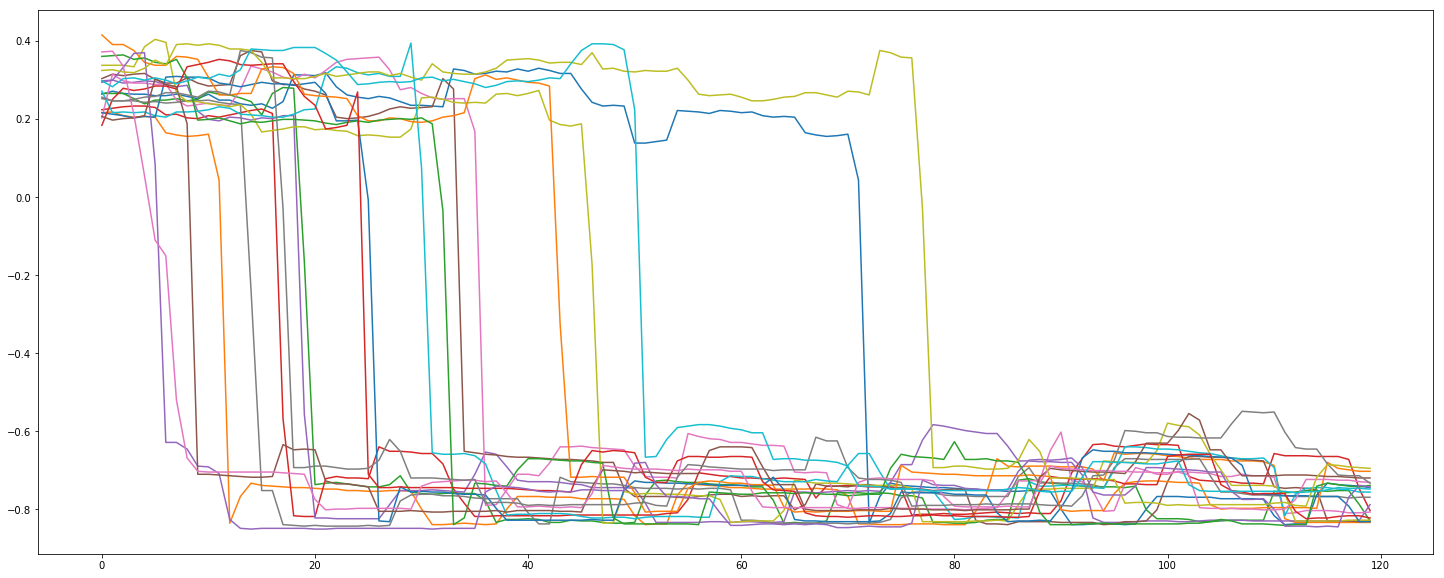

Cluster Size: 19 Cluster # 2


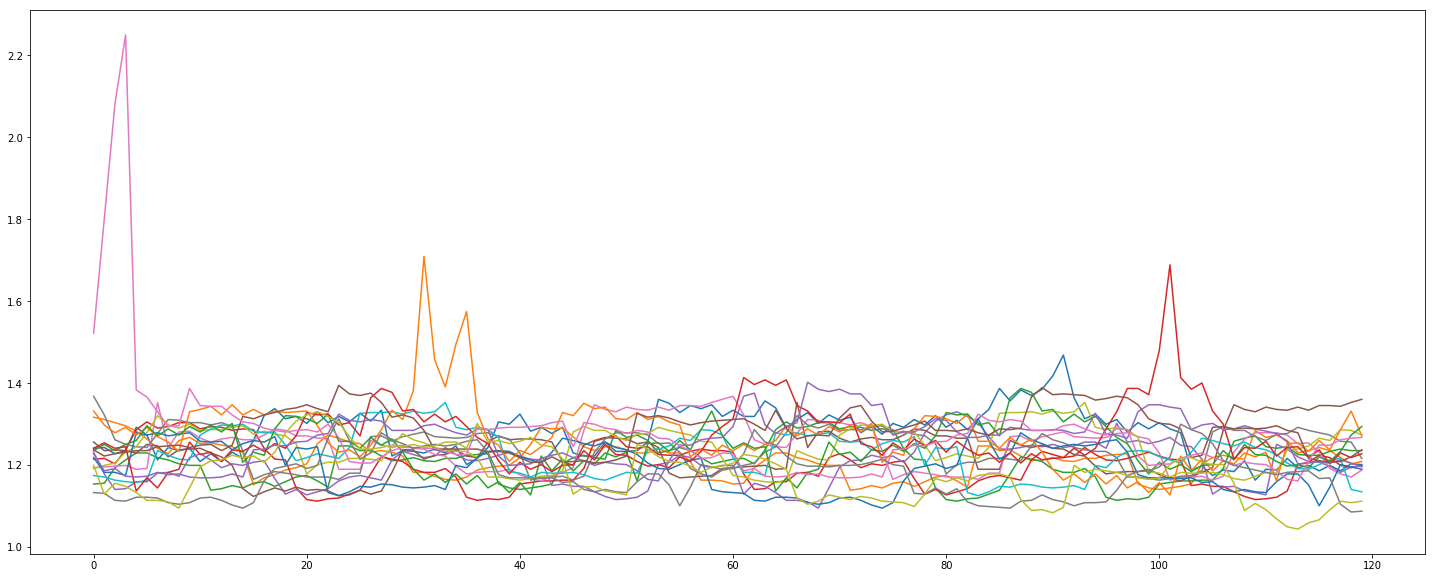

Cluster Size: 12 Cluster # 3


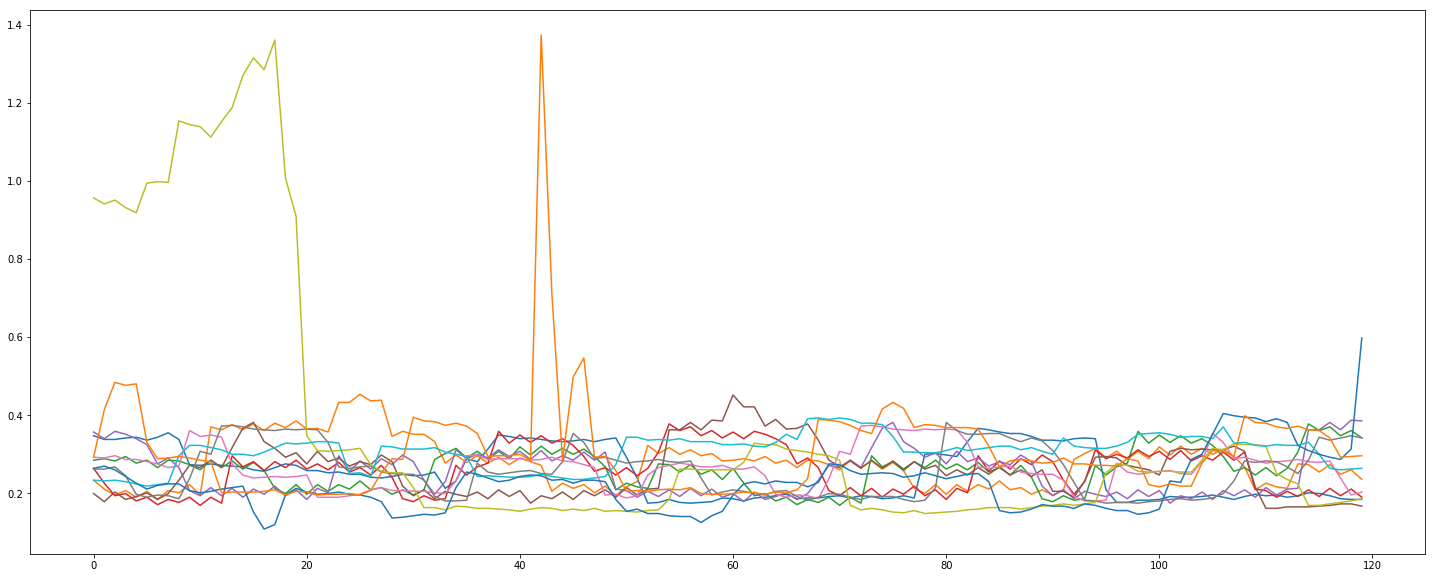

Cluster Size: 12 Cluster # 4


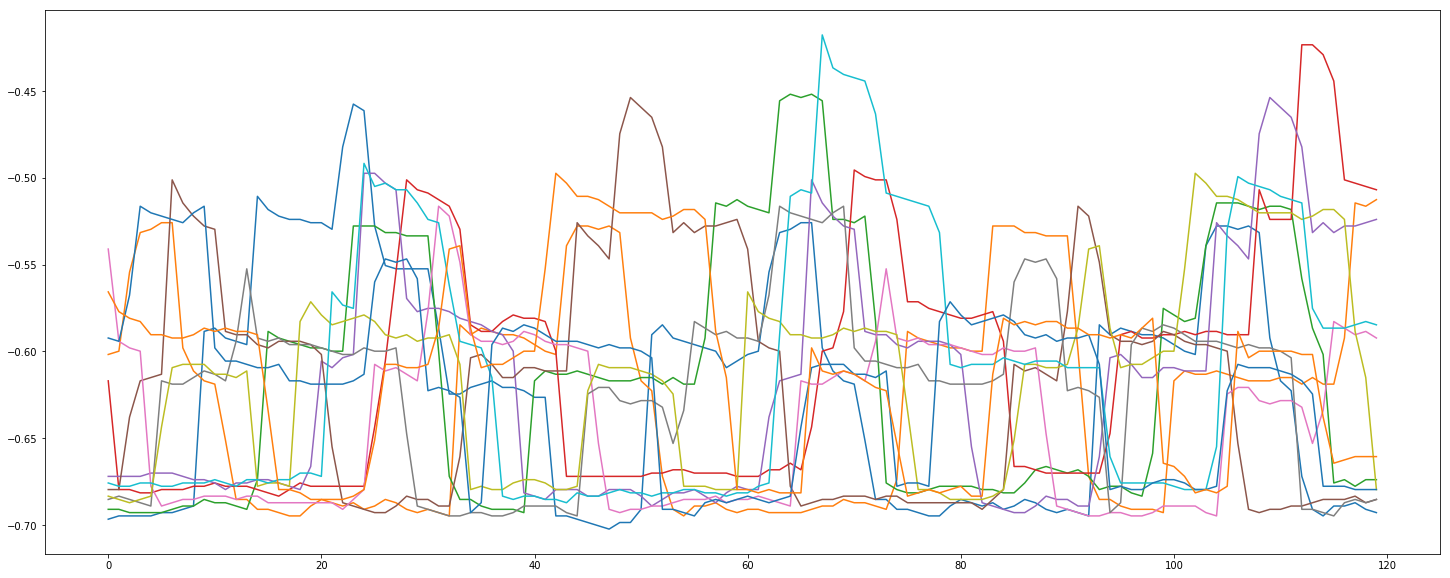

Cluster Size: 7 Cluster # 5


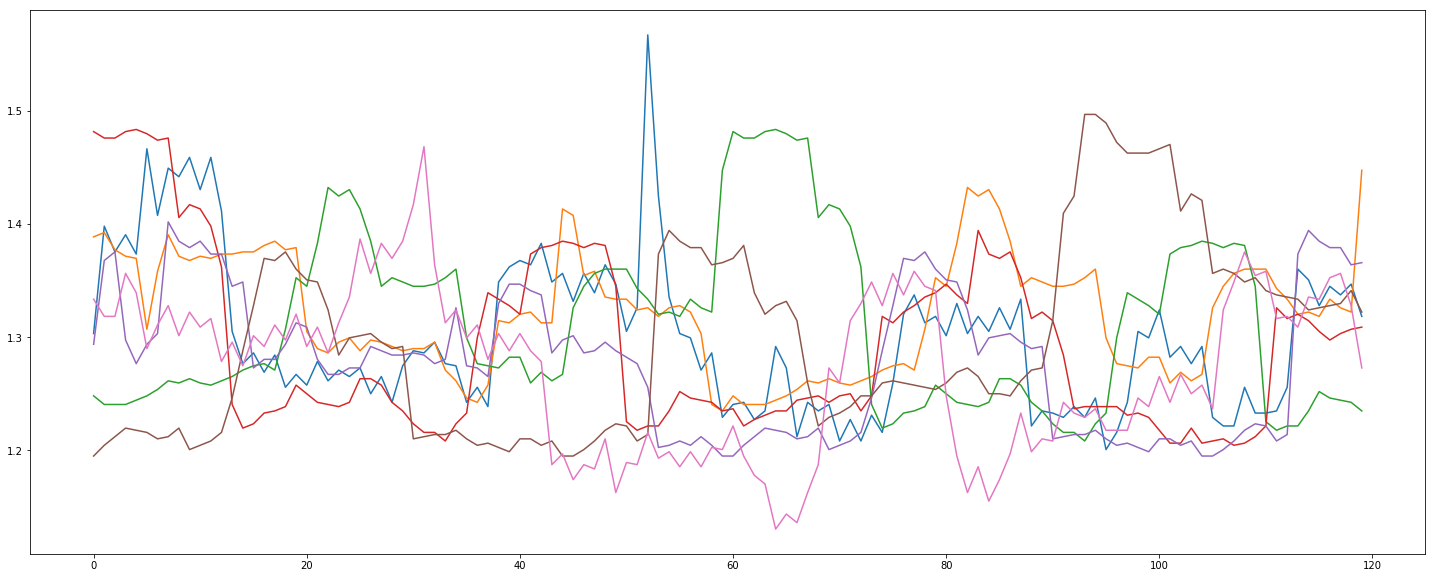

Cluster Size: 7 Cluster # 6


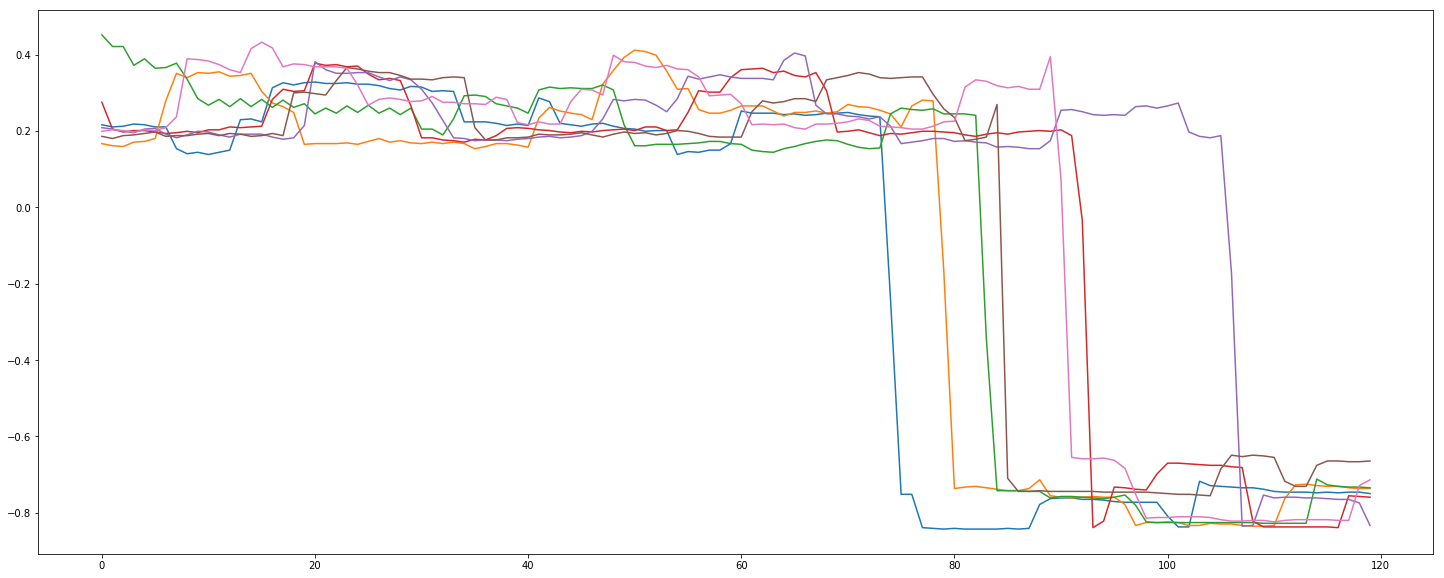

Cluster Size: 7 Cluster # 7


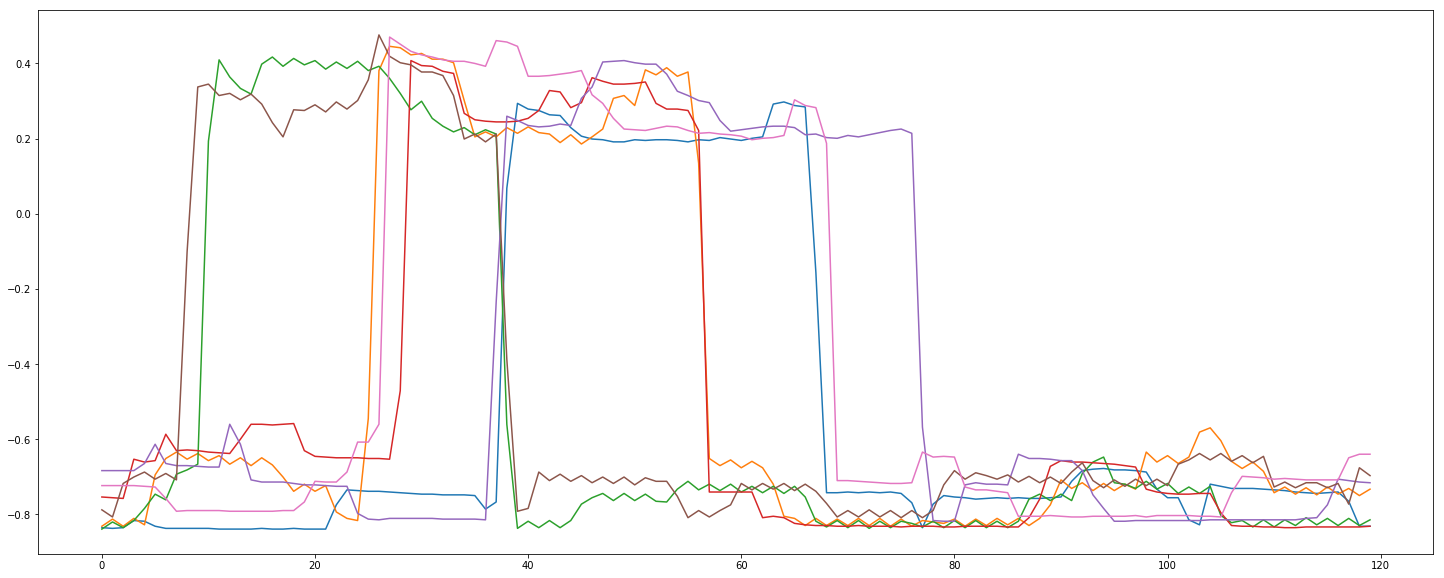

Cluster Size: 7 Cluster # 8


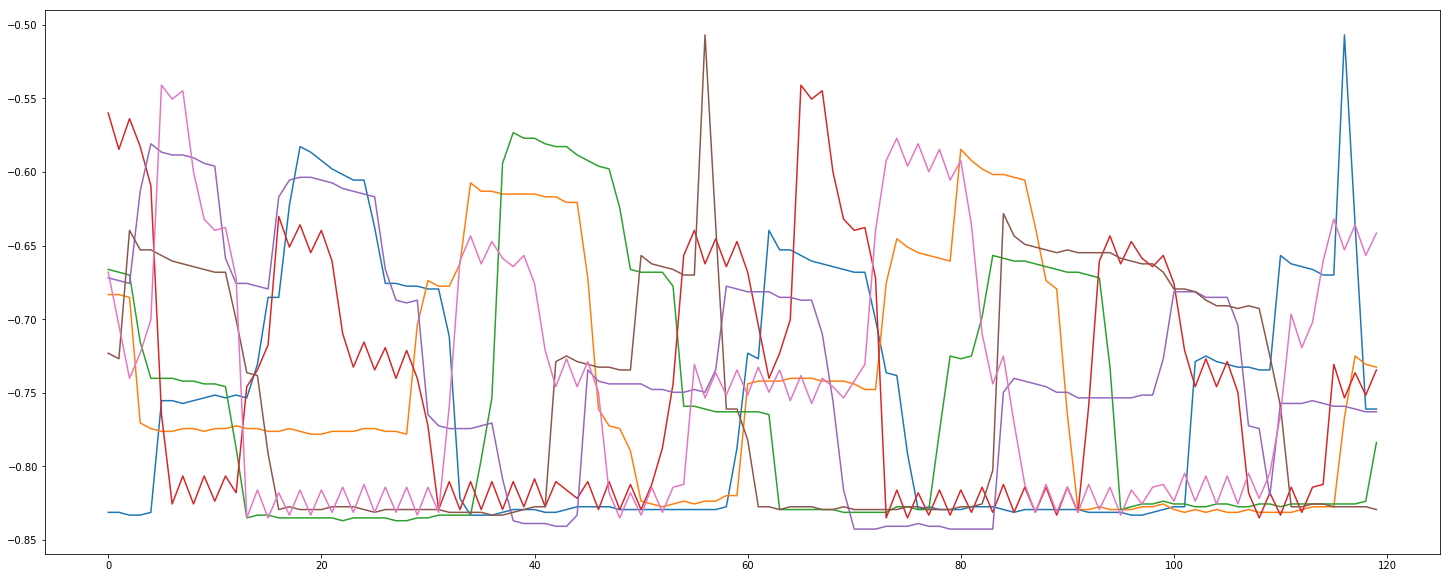

Cluster Size: 7 Cluster # 9


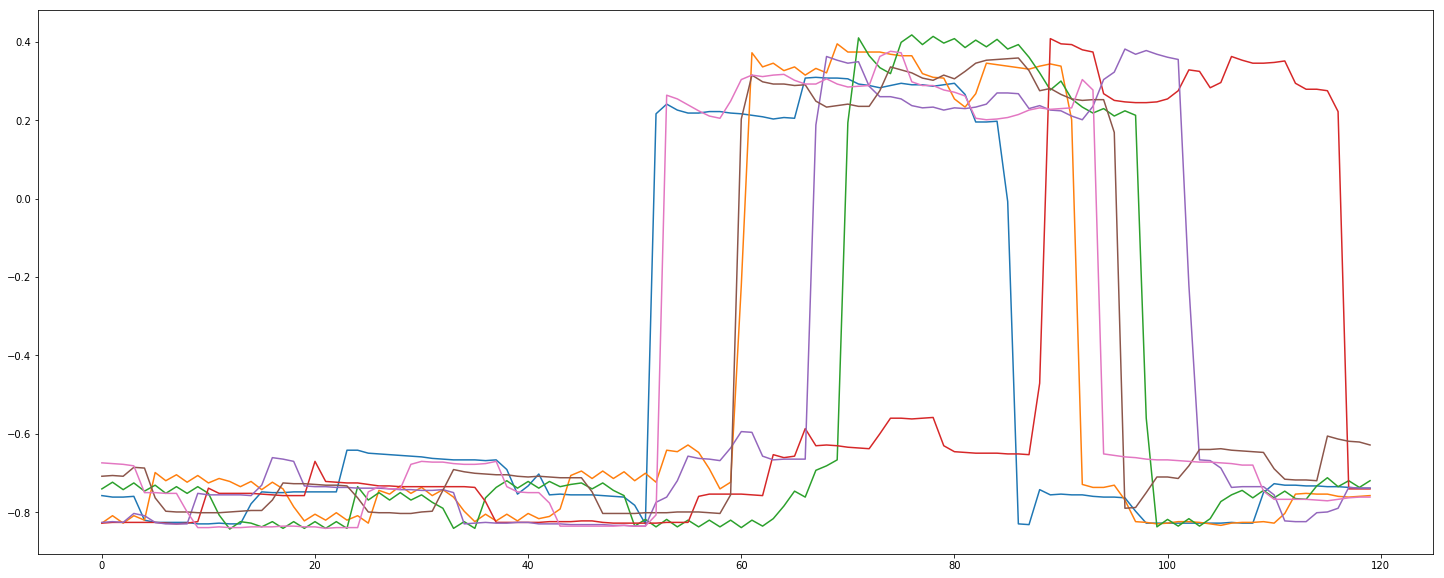

Cluster Size: 7 Cluster # 10


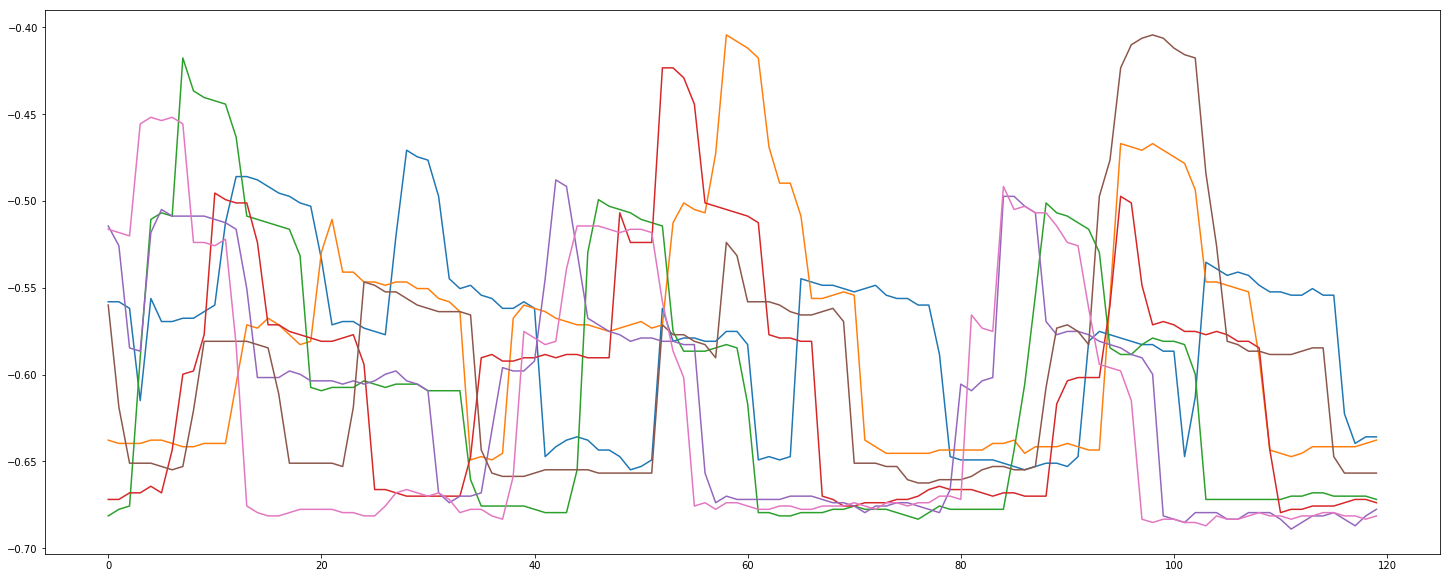

Cluster Size: 6 Cluster # 11


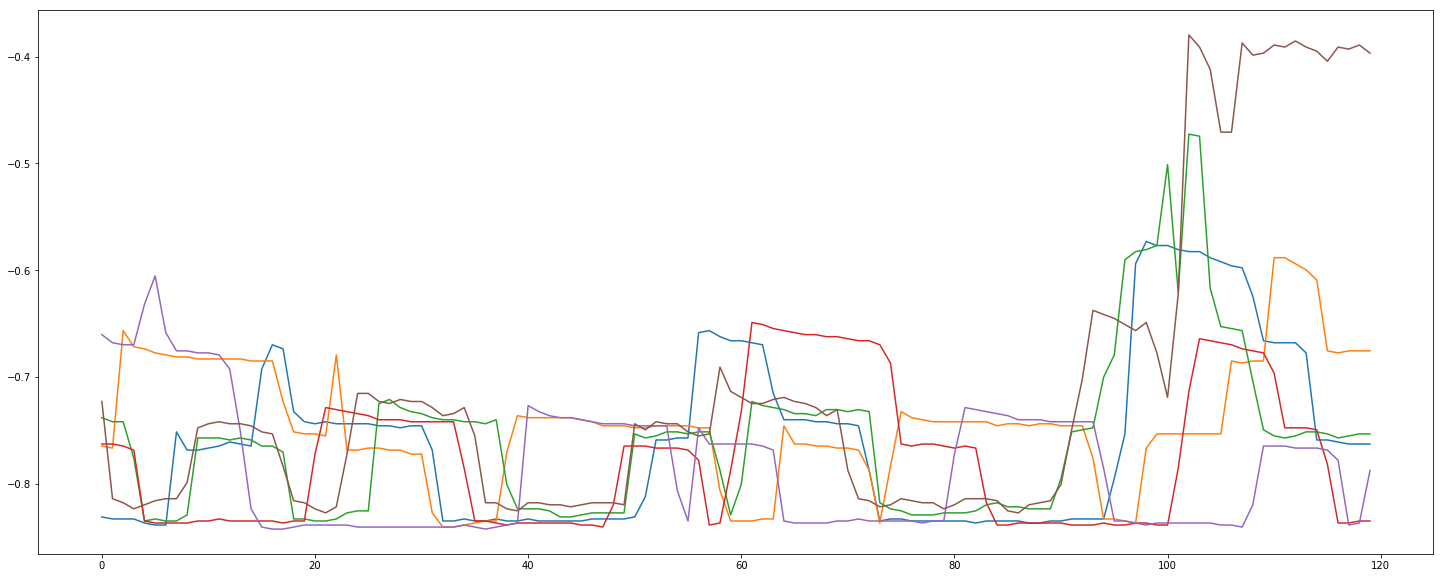

Cluster Size: 5 Cluster # 12


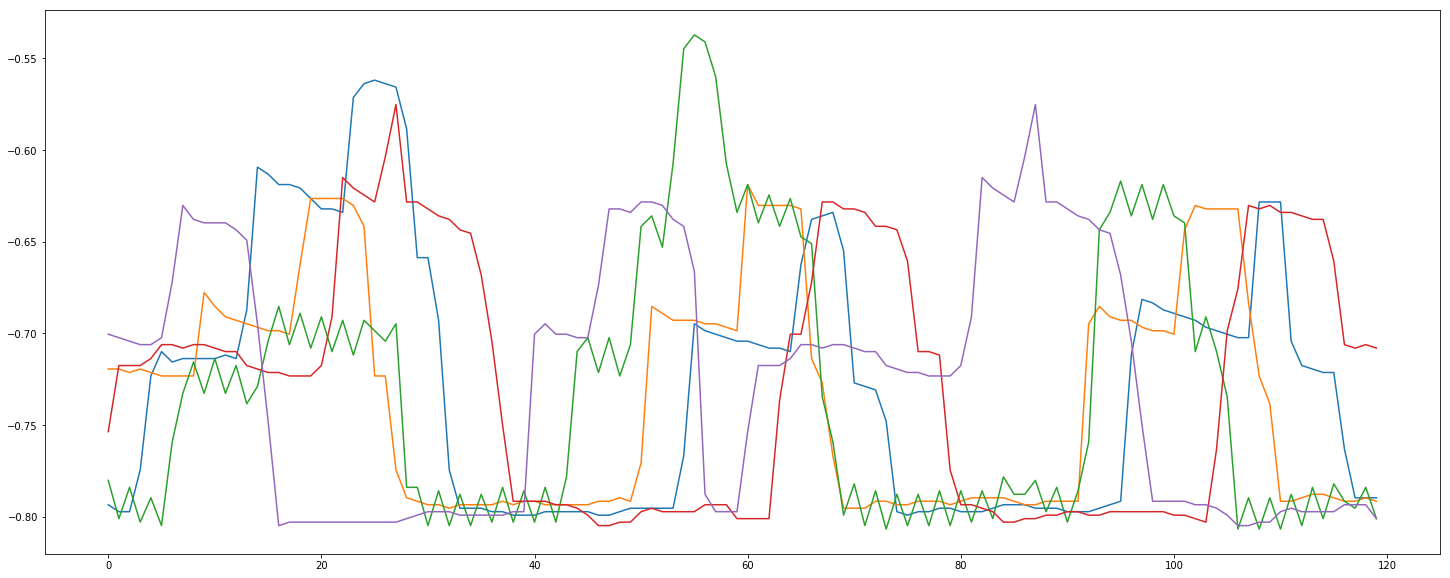

Cluster Size: 5 Cluster # 13


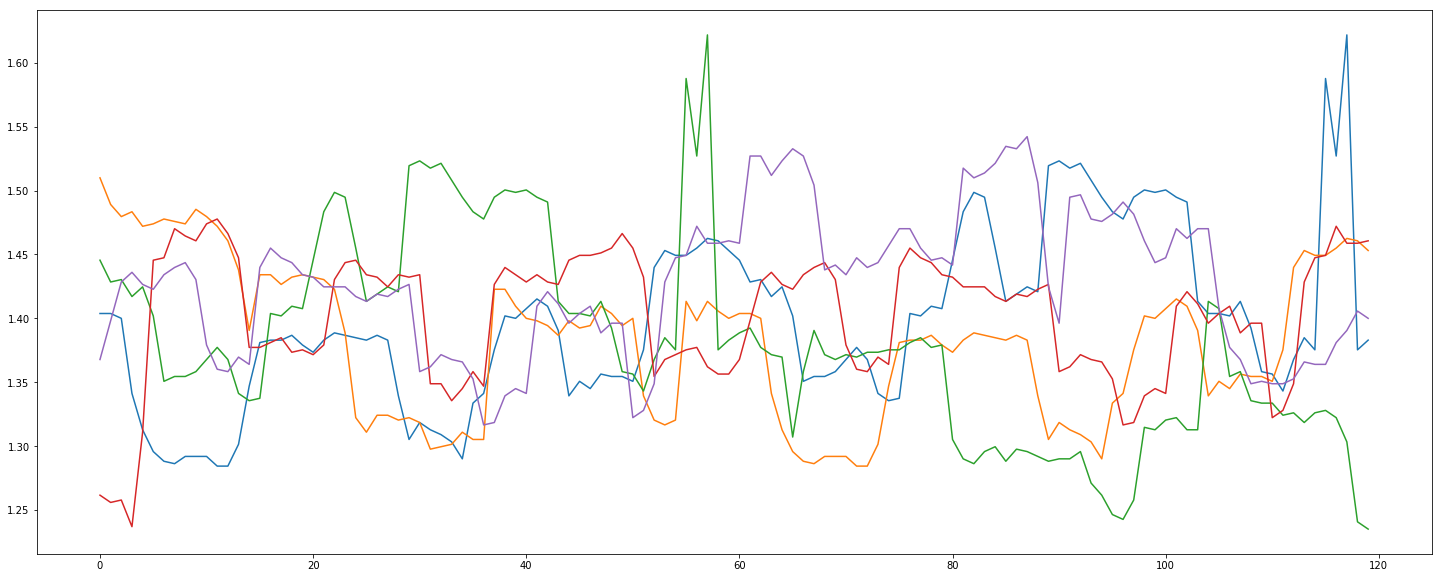

Cluster Size: 5 Cluster # 14


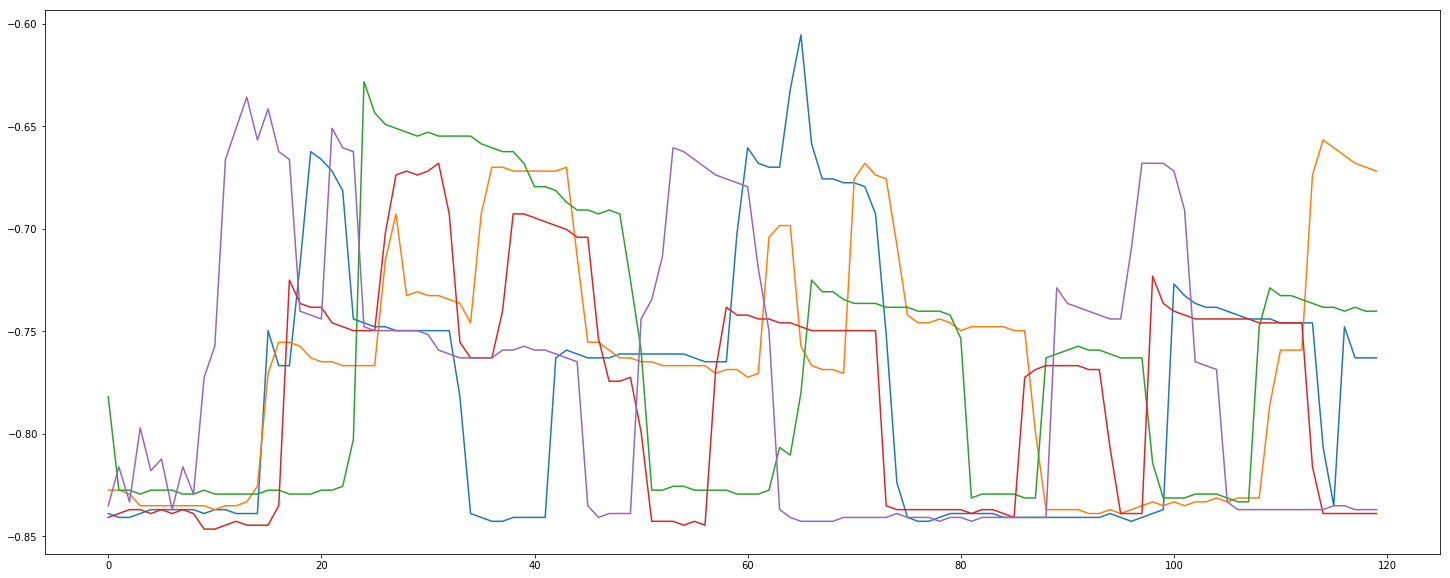

Cluster Size: 5 Cluster # 15


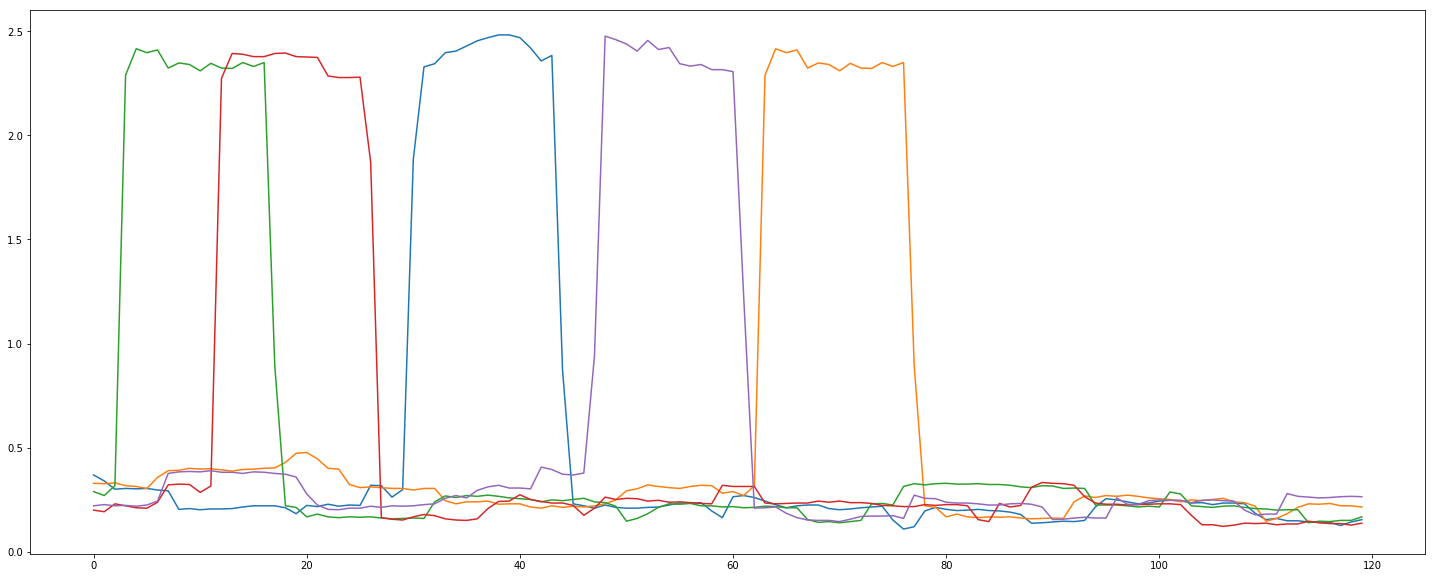

Cluster Size: 5 Cluster # 16


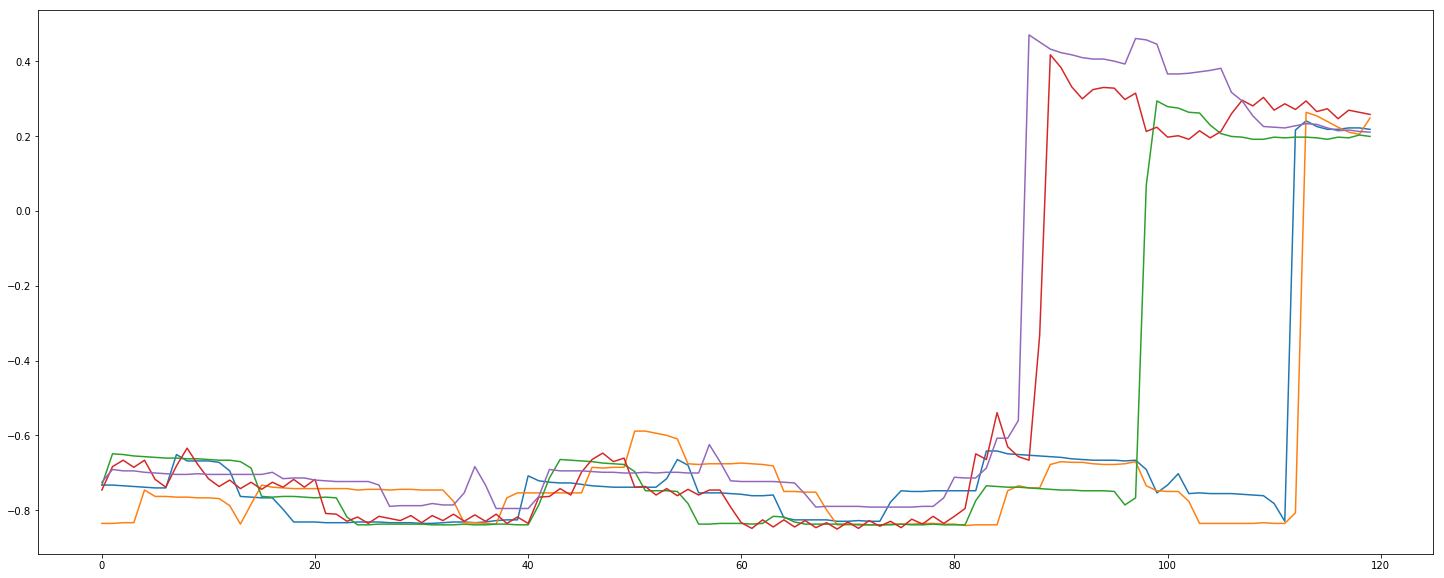

Cluster Size: 5 Cluster # 17


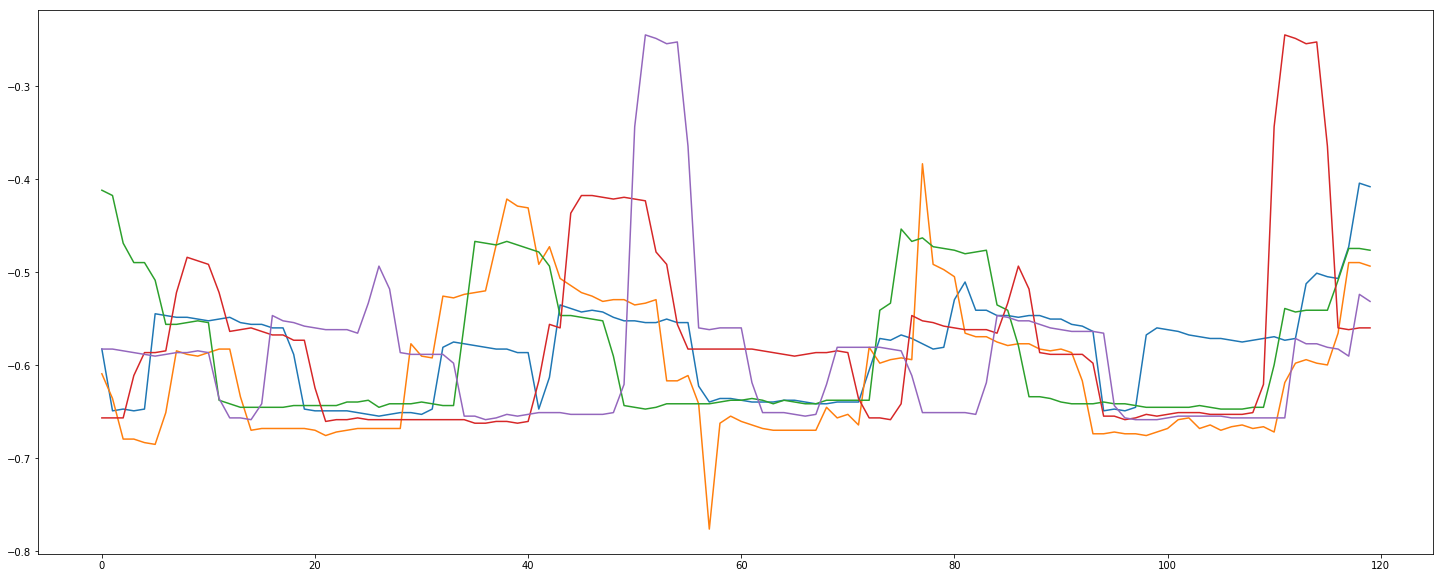

Cluster Size: 4 Cluster # 18


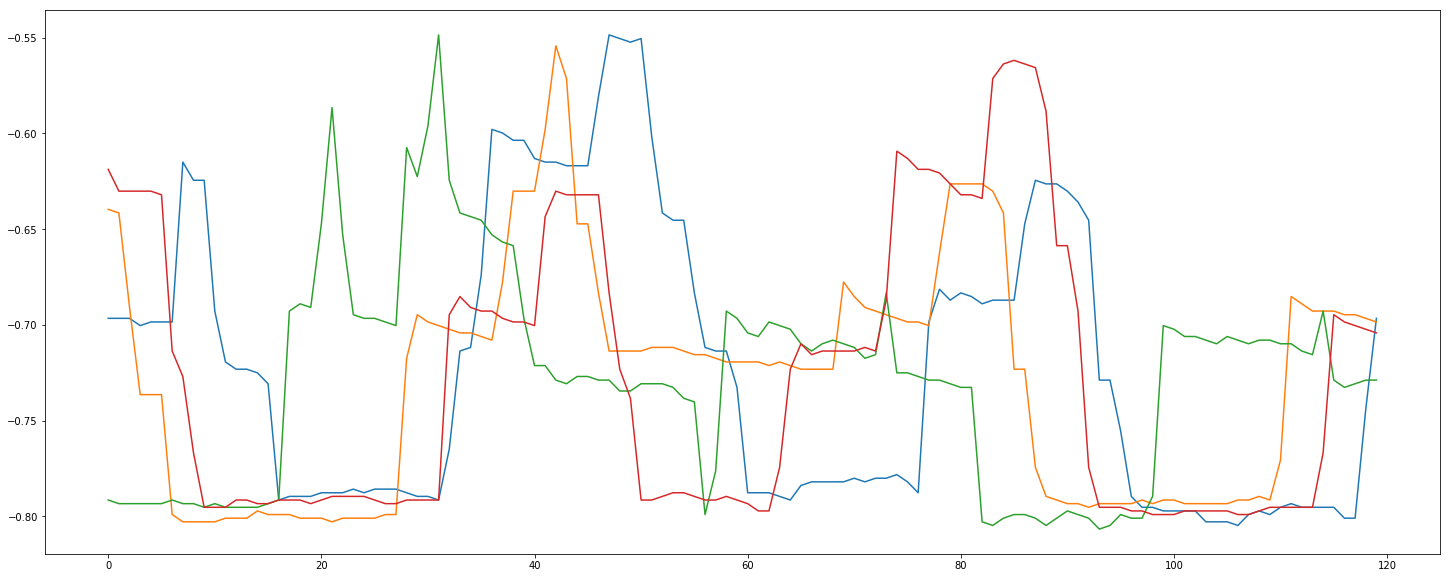

Cluster Size: 4 Cluster # 19


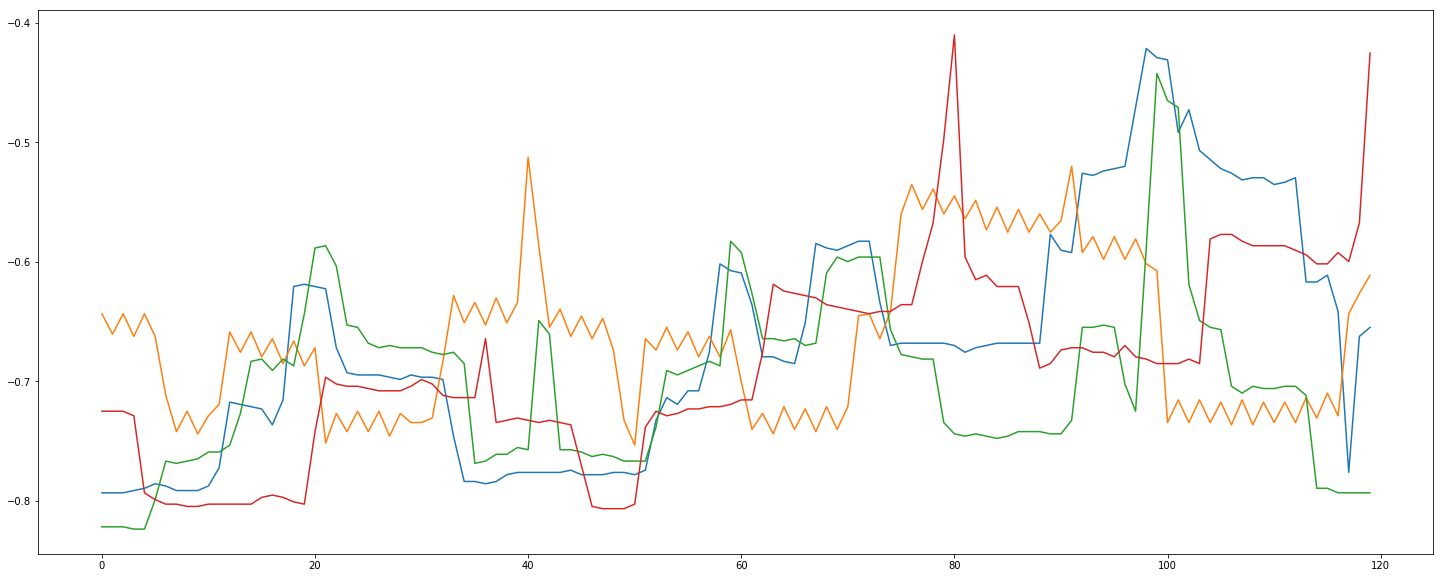

Cluster Size: 4 Cluster # 20


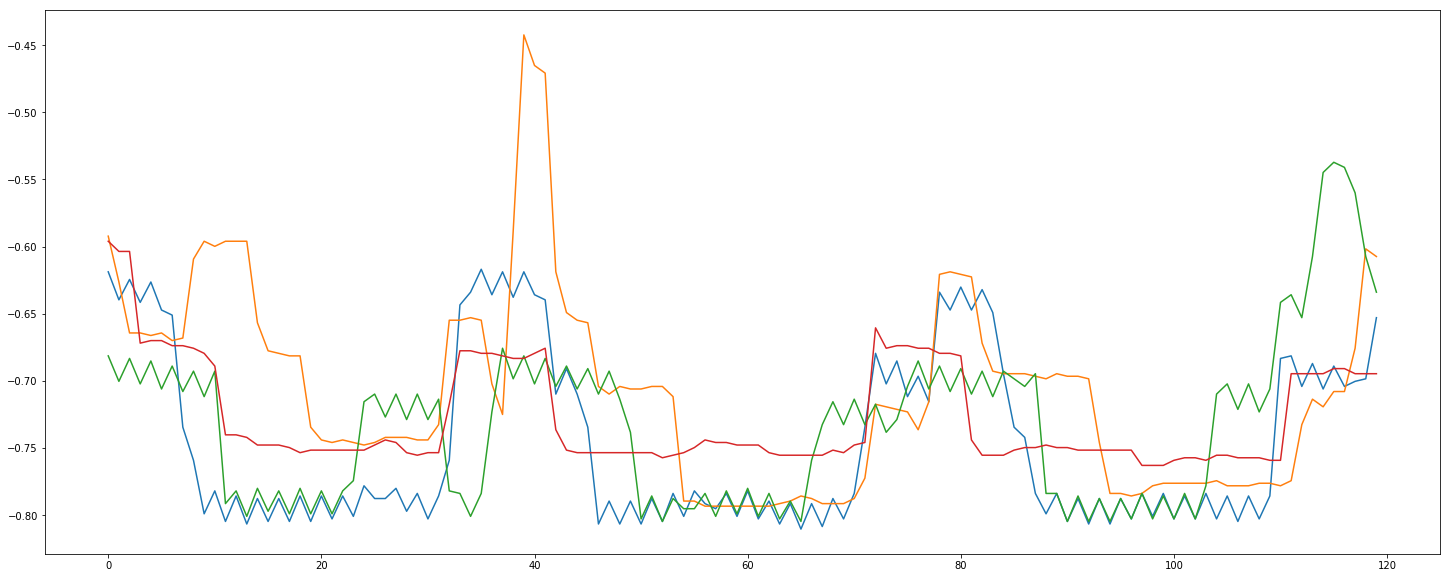

In [10]:
print("Wavelet Count",len(X),"Cluster Count:", len(density_clusters), "Cluster size cut off:", cut_off, "EPS: ", eps)
count = 0
label = []
for i in sorted(density_clusters, key=len, reverse=True):
    print("Cluster Size:", len(i), "Cluster #", count)
    count+=1
    plt.figure(figsize=(25,10))
    for j in i:
        labels = plt.plot(X[int(j)], label='Line '+str(j))
        label.append(labels[0])
   

    plt.show()
    label = []

In [11]:
density_clusters

[[430, 512, 517, 514],
 [476, 460, 474, 519],
 [59, 475, 57, 310],
 [515, 513, 58, 433, 432],
 [368, 367, 369, 377, 378],
 [127, 571, 658, 125, 83],
 [39, 567, 568, 136, 712],
 [608, 33, 130, 69, 509],
 [194, 477, 196, 247, 248],
 [643, 32, 260, 129, 128, 282],
 [297, 370, 371, 372, 362, 363, 299],
 [569, 258, 539, 104, 703, 617, 92],
 [131, 583, 81, 562, 270, 55, 510],
 [656, 606, 644, 318, 30, 657, 319],
 [609, 324, 80, 561, 635, 419, 34],
 [193, 195, 391, 393, 396, 249, 389],
 [616, 534, 535, 536, 537, 538, 701, 702, 544, 427, 40, 91],
 [386, 387, 388, 392, 397, 398, 399, 400, 402, 390, 401, 403],
 [298,
  441,
  442,
  443,
  444,
  464,
  465,
  466,
  467,
  468,
  469,
  222,
  223,
  224,
  361,
  373,
  360,
  470,
  445],
 [640,
  641,
  259,
  271,
  655,
  35,
  420,
  570,
  704,
  93,
  610,
  487,
  105,
  618,
  124,
  511,
  416,
  429,
  428,
  309],
 [516,
  518,
  31,
  558,
  559,
  560,
  563,
  56,
  572,
  67,
  68,
  584,
  585,
  586,
  587,
  79,
  82,
  607,

In [12]:
freqtime = []
i = 0
for cluster in density_clusters:
    new_clust = []
    for time_slice in cluster:
        new_clust.append(time_slice%24)
    freq_val_list = collections.Counter(new_clust)
    inverse = [(value, key) for key, value in freq_val_list.items()]
    percent = (max(inverse)[0])/len(cluster)
    if(percent > 0.1 and len(cluster)>10):
        freqtime.append((pd.to_timedelta(max(inverse)[1], unit='h') + pd.to_datetime('17:24:00') , max(inverse)[0], i, len(cluster)))
    i += 1
print(len(freqtime))
print(freqtime)
freq_clusters = [x[2] for x in freqtime]

# These are the 5 clusters where the recurring patterns occurred at nearly the same time of day for the month

4
[(Timestamp('2018-11-24 09:24:00'), 3, 16, 12), (Timestamp('2018-11-24 06:24:00'), 3, 18, 19), (Timestamp('2018-11-24 00:24:00'), 4, 19, 20), (Timestamp('2018-11-24 04:24:00'), 9, 20, 57)]


Wavelet Count 34586 Cluster Count: 21 Cluster size cut off: 3 EPS:  0.025
Cluster Size: 5 Cluster # 16


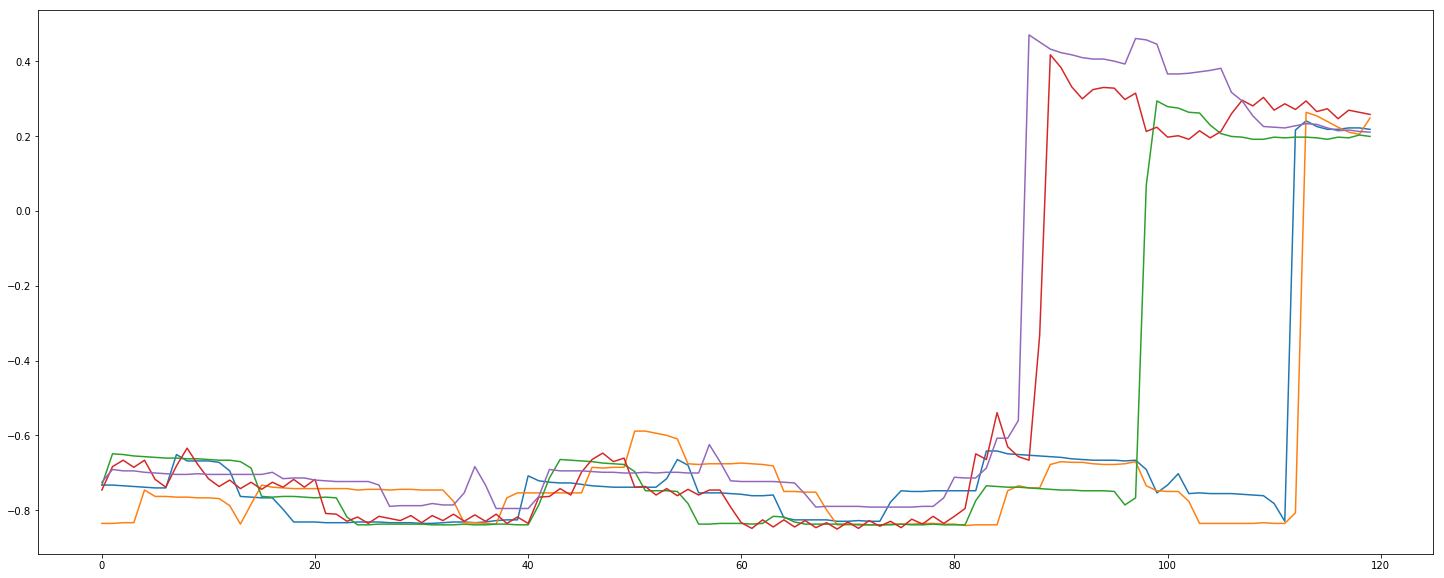

Cluster Size: 4 Cluster # 18


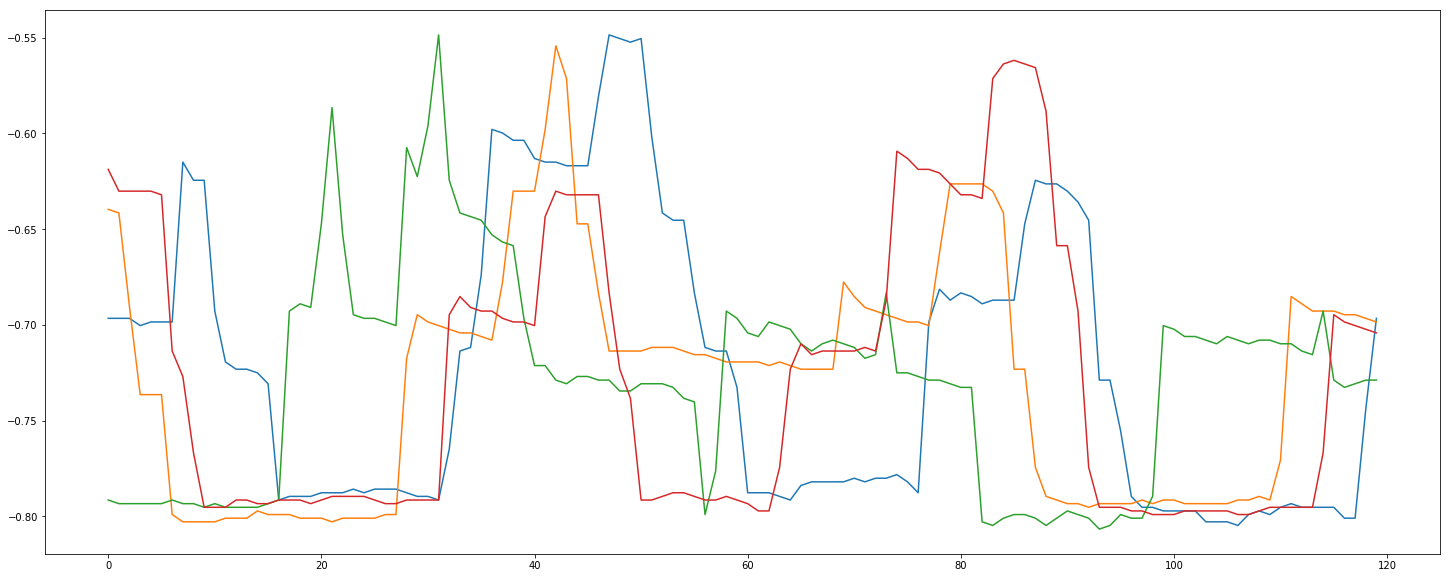

Cluster Size: 4 Cluster # 19


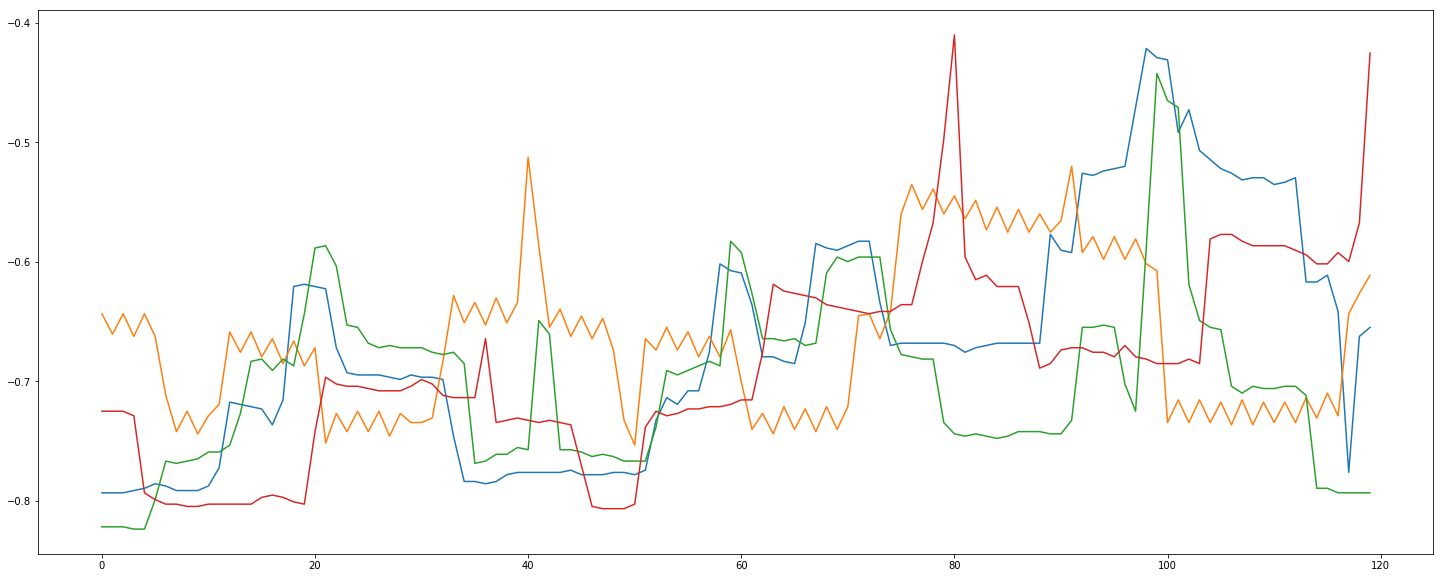

Cluster Size: 4 Cluster # 20


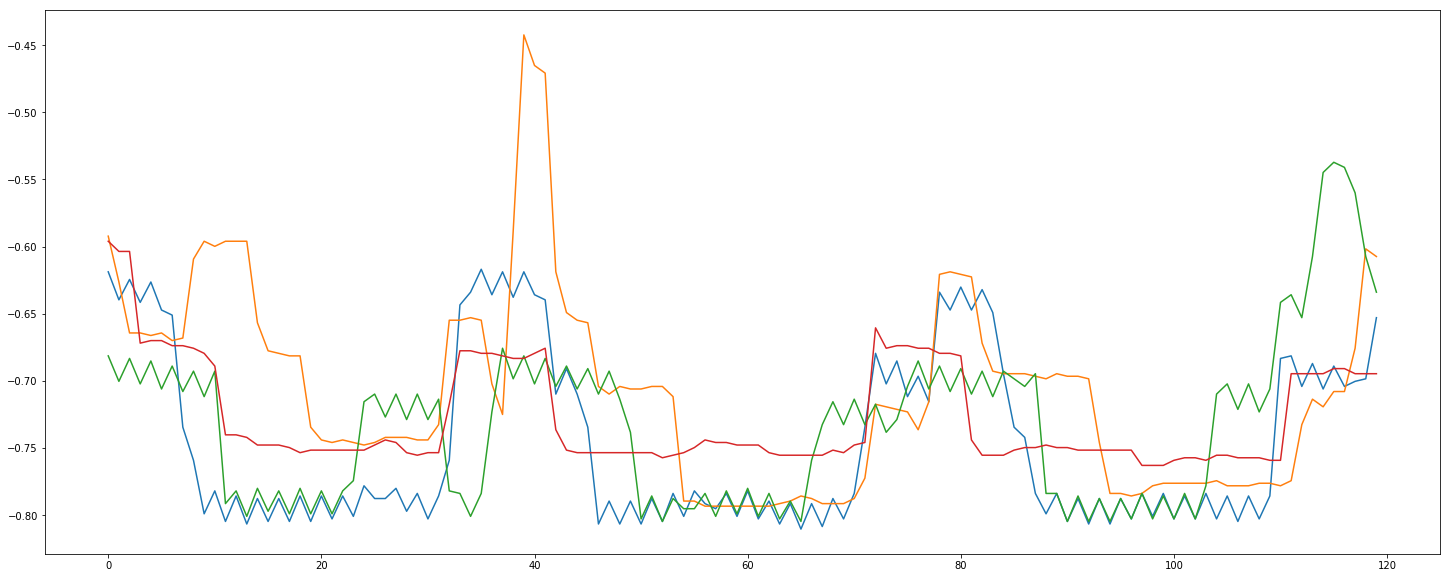

In [13]:
print("Wavelet Count",len(X),"Cluster Count:", len(density_clusters), "Cluster size cut off:", cut_off, "EPS: ", eps)
count = 0
label = []
for i in sorted(density_clusters, key=len, reverse=True):
    if(count in freq_clusters):
        print("Cluster Size:", len(i), "Cluster #", count)
        plt.figure(figsize=(25,10))
        for j in i:
            labels = plt.plot(X[int(j)], label='Line '+str(j))
            label.append(labels[0])
        plt.show()
        label = []
    count+=1

In [14]:
freq_clusters

[16, 18, 19, 20]